In [2]:
import sys
sys.path.append("../")

In [14]:
import statistics
from collections import defaultdict

import pandas
import pandas as pd
from typing import Set

from real_robots_dont_cry.gensurvey import ExpectedPossible
from real_robots_dont_cry.join_results import get_joined_results, get_df_with_responses_count


def get_task_ids_with_acceptable_dup_diff(df, squared_diff_limit: float = 8) -> Set:
    """Check to see if the duplicate question has similar responses to the
    original question."""
    question_topic_to_diffs = defaultdict(list)
    passing_requirement_task_ids = set()
    for _, df_group in df.groupby('task_id'):
        total_diff = 0
        total_diff_squared = 0
        for non_dup, dup in matched_duplicate_rows(df_group):
            answer_diff = abs(non_dup['ans'] - dup['ans'])
            question_topic_to_diffs[non_dup['question_topic']].append(answer_diff)
            total_diff += answer_diff
            total_diff_squared += answer_diff ** 2
            question_topic_to_diffs[non_dup['question_topic'] + "_pair"].append((non_dup['ans'], dup['ans']))
        total_diff += answer_diff
        question_topic_to_diffs['total'].append(total_diff)
        question_topic_to_diffs['total_squared'].append(total_diff_squared)
        if total_diff_squared <= squared_diff_limit:
            passing_requirement_task_ids.add(df_group['task_id'].iloc[0])
    #print(f"{question_topic_to_diffs['total_squared']=}")
    #print(f"{statistics.mean(question_topic_to_diffs['total_squared'])=}")
    #print(f"{statistics.stdev(question_topic_to_diffs['total_squared'])=}")
    return passing_requirement_task_ids


def is_a_quality_check_row(df):
    return df['dataset_src'] == 'quality_check'


def get_task_ids_pass_ans_diversity(df, std_limit=0.33):
    df = df[~df['is_human'] & ~df['is_duplicate'] & ~is_a_quality_check_row(df)]
    #print("STANDARD DEVIATION ALL")
    #print(f"{df['ans'].std()}")
    aggregated = df.groupby('task_id')['ans'].agg(['count', 'mean', 'std'])
    return set(aggregated.index[aggregated['std'] >= std_limit])


def get_task_ids_pass_quality_check_question(df):
    num_task_ids = len(df.task_id.unique())
    df = df[is_a_quality_check_row(df)]
    assert len(df) == num_task_ids * 4
    df = df[df.apply(_is_quality_check_resp_acceptable, axis=1)]
    pass_counts = df.groupby('task_id')['ans'].agg(['count'])
    max_pass = int(pass_counts.max())
    return set(pass_counts.index[pass_counts['count'] == max_pass])
    # print_all(df)
    # print(df['expect_robot_possible'])


def get_task_ids_long_enough_explan(df):
    df = df[df.user_explanation.notnull()]
    df = df[(
        ((df.ans >= 5) & (df.user_explanation.str.count(' ') >= 0))
        | ((df.ans >= 3) & (df.user_explanation.str.count(' ') >= 3))
        | (df.user_explanation.str.count(' ') >= 5)
    )]
    pass_counts = df.groupby('task_id')['ans'].agg(['count'])
    max_pass = int(pass_counts.max())
    return set(pass_counts.index[pass_counts['count'] == max_pass])


def _is_quality_check_resp_acceptable(resp_row):
    if resp_row['q_kind'] == 'truthful':
        check_row = 'expect_human_possible' if resp_row['is_human'] else 'expect_robot_possible'
        if (
            resp_row[check_row] == ExpectedPossible.HIGH.value
            and resp_row['ans'] <= 2
        ):
            #print("TOO LOW", resp_row['resp_cat'], resp_row['ans'], resp_row['turn_b'])
            return False
        elif (
            resp_row[check_row] == ExpectedPossible.LOW.value
            and resp_row['ans'] >= 4
        ):
            #print("TOO HIGH", resp_row['resp_cat'], resp_row['ans'], resp_row['turn_b'])
            return False
    elif resp_row['q_kind'] == 'comfort':
        if resp_row['is_human'] and resp_row['ans'] <= 1:
            #print("TOO LOW HUMAN COMPFORT", resp_row['resp_cat'], resp_row['ans'], resp_row['turn_b'])
            return False  # We expect them all to be comfortable for a human
    else:
        raise ValueError(f"Unknown q_kind: {resp_row['q_kind']}")
    return True


def matched_duplicate_rows(df):
    non_dups = df[~df['is_duplicate']]
    for _, item in df[df['is_duplicate']].iterrows():
        non_dup_version = non_dups[
            (non_dups['text_hash'] == item['text_hash'])
            & (non_dups['question_topic'] == item['question_topic'])
            & (non_dups['task_id'] == item['task_id'])
        ]
        assert len(non_dup_version) == 1
        yield (non_dup_version.iloc[0], item)


DEFAULT_MAX_WORKER_HIT_NUM = 5


def get_task_ids_that_pass_all_checks(
    df,
    verbose=True,
    consider_free_resp=True,
    max_worker_hit_num: int = DEFAULT_MAX_WORKER_HIT_NUM,
    max_worker_text_num: int = 1,
):
    if verbose:
        print(f"Num HITs before filtering: {len(df.task_id.unique())}")
    df = df[df['worker_id_hash'].notnull()]
    if verbose:
        print(f"Num HITs after filtering no worker_id: {len(df.task_id.unique())}")
    df = df[df['worker_hit_num'] <= max_worker_hit_num]
    if verbose:
        print(f"Num HITs after filtering more than {max_worker_hit_num} worker hits: {len(df.task_id.unique())}")
        print(f"Num Texts after filtering more than {max_worker_hit_num} worker hits: {len(df.text_hash.unique())}")
    dup_pass = get_task_ids_with_acceptable_dup_diff(df)
    df = df[(
        (df['worker_text_num'] <= max_worker_text_num)
        | is_a_quality_check_row(df)  # It's ok to see same quality multiple times
    )]
    if verbose:
        print(f"Num HITs after filtering worker doing text repeat {max_worker_text_num}: {len(df.task_id.unique())}")
        print(
            f"Num texts after filtering worker doing text repeat {max_worker_text_num}: {len(df.text_hash.unique())}")
    diversity_pass = get_task_ids_pass_ans_diversity(df)
    if verbose:
        print("HITs that fail diversity pass", set(df.task_id.unique()) - diversity_pass)
    pass_quality_question = get_task_ids_pass_quality_check_question(df)
    if consider_free_resp:
        pass_explan_long_enough = get_task_ids_long_enough_explan(df)
    else:
        pass_explan_long_enough = set(df.task_id.unique())
    pass_all = (dup_pass & diversity_pass
                & pass_quality_question & pass_explan_long_enough)
    if verbose:
        from matplotlib import pyplot as plt
        import exlib.venn
        print(f"{len(df['task_id'].unique())=}")
        print(f"{len(dup_pass)=}")
        print(f"{len(diversity_pass)=}")
        print(f"{len(pass_quality_question)=}")
        print(f"{len(pass_explan_long_enough)=}")
        print(f"{len(pass_all)=}")
        exlib.venn.venn4(
            exlib.venn.get_labels(
                [dup_pass, diversity_pass, pass_quality_question, pass_explan_long_enough],
            ),
            ['dup_pass', 'diversity_pass', 'pass_quality_question', 'pass_explan_long_enough'],
        )
        plt.show()
        
        
        # analysis
        exlib.venn.venn3(
            exlib.venn.get_labels(
                [dup_pass, diversity_pass, pass_quality_question],
            ),
            ['dup_pass', 'diversity_pass', 'pass_quality_question'],
        )
        plt.show()
        exlib.venn.venn3(
            exlib.venn.get_labels(
                [dup_pass, diversity_pass, pass_explan_long_enough],
            ),
            ['dup_pass', 'diversity_pass', 'pass_explan_long_enough'],
        )
        plt.show()
        
        pass_quality = (pass_quality_question & pass_explan_long_enough)
        
        exlib.venn.venn3(
            exlib.venn.get_labels(
                [dup_pass, diversity_pass, pass_quality],
            ),
            ['dup_pass', 'diversity_pass', 'pass_quality'],
        )
        plt.show()
        
        exlib.venn.venn2(
            exlib.venn.get_labels(
                [diversity_pass, pass_quality],
            ),
            ['diversity_pass', 'pass_quality'],
        )
        plt.show()
        
        diversity_pass = get_task_ids_pass_ans_diversity(dup_pass)
        pass_quality_question = get_task_ids_pass_quality_check_question(dup_pass)
        pass_explan_long_enough = get_task_ids_long_enough_explan(dup_pass)
        pass_quality = (pass_quality_question & pass_explan_long_enough)
        exlib.venn.venn2(
            exlib.venn.get_labels(
                [diversity_pass, pass_quality],
            ),
            ['diversity_pass', 'pass_quality'],
        )
        plt.show()
    return pass_all


def filter_df_by_pass_quality(
    df,
    consider_free_resp: bool = True,
    max_worker_hit_num: int = DEFAULT_MAX_WORKER_HIT_NUM,
    max_worker_text_num: int = 1,
):
    return df[df['task_id'].isin(get_task_ids_that_pass_all_checks(
        df,
        consider_free_resp=consider_free_resp,
        max_worker_hit_num=max_worker_hit_num,
        max_worker_text_num=max_worker_text_num,
    ))]


def get_filtered_joined_results(
    remove_duplicates: bool = True,
    max_worker_hit_num: int = 3,
    max_worker_text_num: int = 1,
    filter_by_free_resp_explan_long_enough: bool = True,
) -> pd.DataFrame:
    df = get_joined_results()
    df = filter_df_by_pass_quality(
        df,
        max_worker_hit_num=max_worker_hit_num,
        max_worker_text_num=max_worker_text_num,
        consider_free_resp=filter_by_free_resp_explan_long_enough,
    )
    df = df[~is_a_quality_check_row(df)]
    if remove_duplicates:
        df = df[~df['is_duplicate']]
    return df


def filter_df_by_text_responses_threshold(
    df,
    threshold_responses: int
) -> pandas.DataFrame:
    return df[df[~df['is_duplicate']].groupby(['text_hash', 'resp_cat'])['ans'].transform('size') >= threshold_responses]


def get_fraction_that_would_need_revote(df):
    df['question_topic'] == 'robot-comfort'
    df.groupby('text_hash').count()

len(responses)=837
type(responses)=<class 'list'>
len(surveys)=416
Num HITs before filtering: 837
Num HITs after filtering no worker_id: 780
Num HITs after filtering more than 3 worker hits: 755
Num Texts after filtering more than 3 worker hits: 904
Num HITs after filtering worker doing text repeat 1: 755
Num texts after filtering worker doing text repeat 1: 904
HITs that fail diversity pass {'235d5c6a-f37b-4ee2-b552-d20ece4ac9c5', '9c1fc776-f450-4340-af59-0e32594e71e0', '28c842e4-9b71-48d8-84cf-dfca6ad9beb1', 'cc9ec650-04d3-464a-81cc-01dfe3e56a84', 'd9411b2b-78ca-4f6e-b396-8b18cc3adafe', 'b9f2ba12-aafb-404f-84cd-beb85223946e', 'b4f1524a-7a90-4486-b455-dfce34ab7bcc', '7fb908d5-db93-4e26-b4f0-dd8a8113054f', '6dd8a346-3b94-4cd6-a716-9742341b6a8b', '6ccbd69d-120b-4ec3-b2c1-6b661bd08c52', '2bdb52c3-ee18-4602-98ca-104dad2c67de', 'e3a9870b-5726-4b3c-bdc3-8bb8e39d301b', 'f6385bed-5a31-4341-89b3-c4f033d1da4a', 'c9ac687d-05fb-4811-93de-75034b458e7f', 'b69f36e7-eebe-4a91-9229-fd40bb554c2d', '1a0

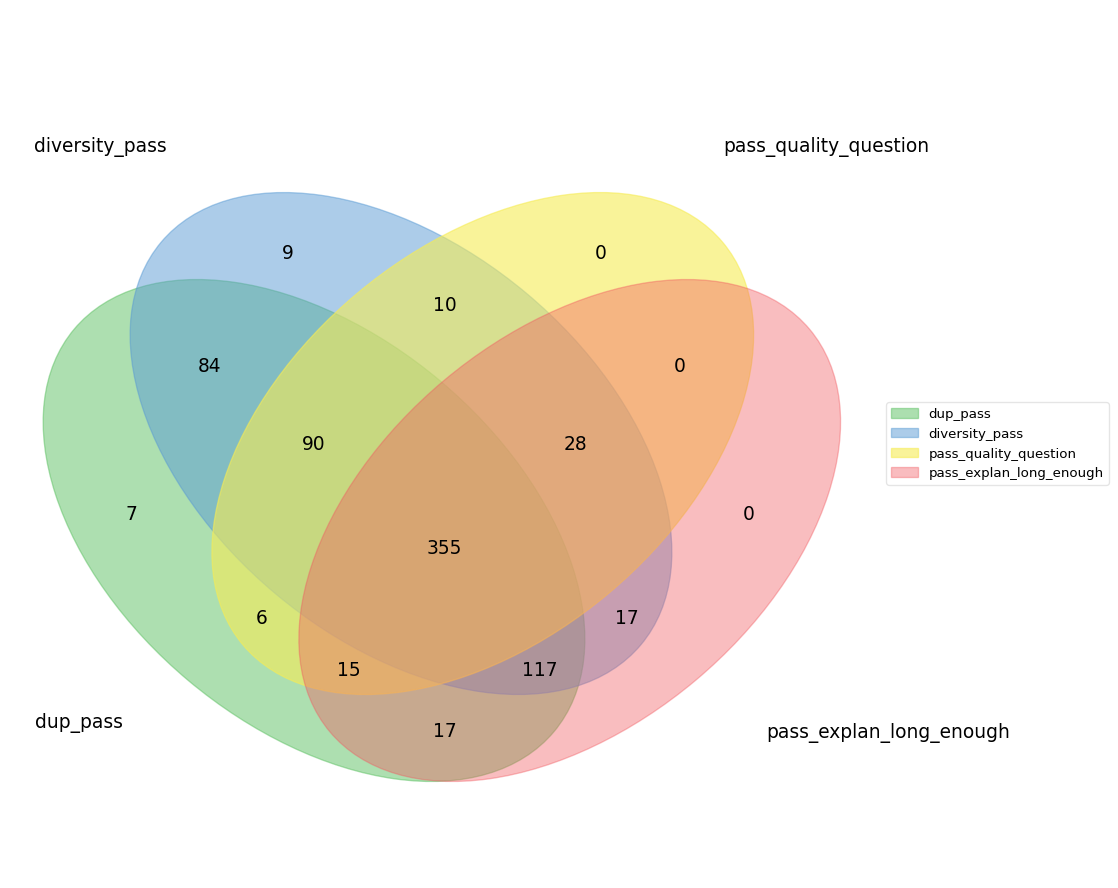

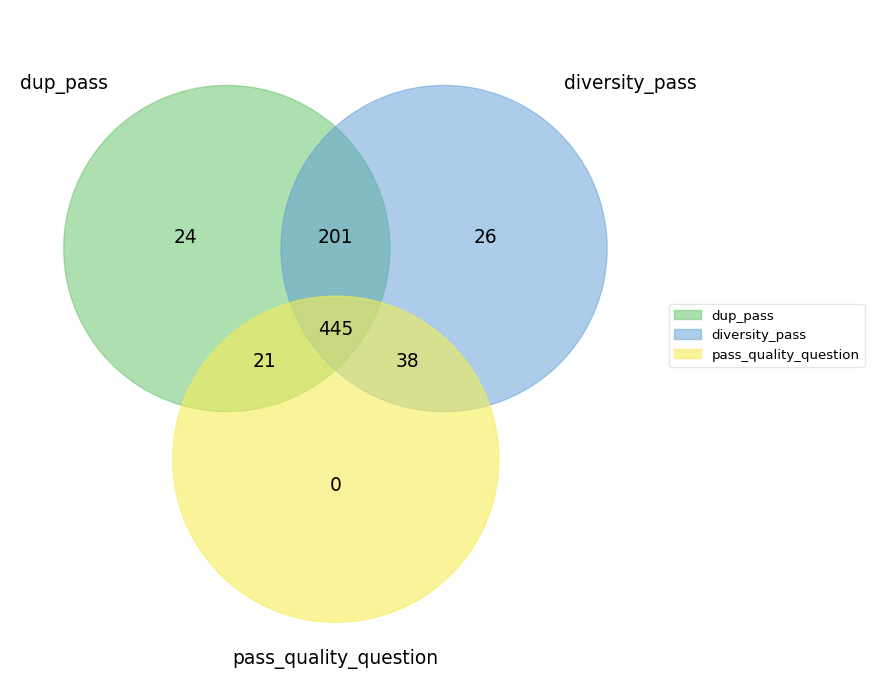

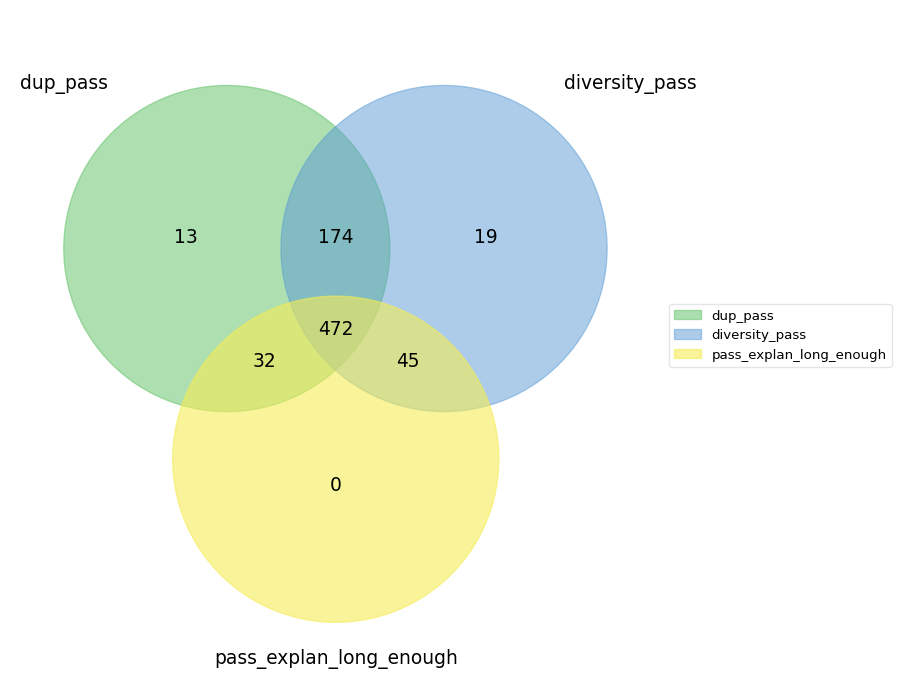

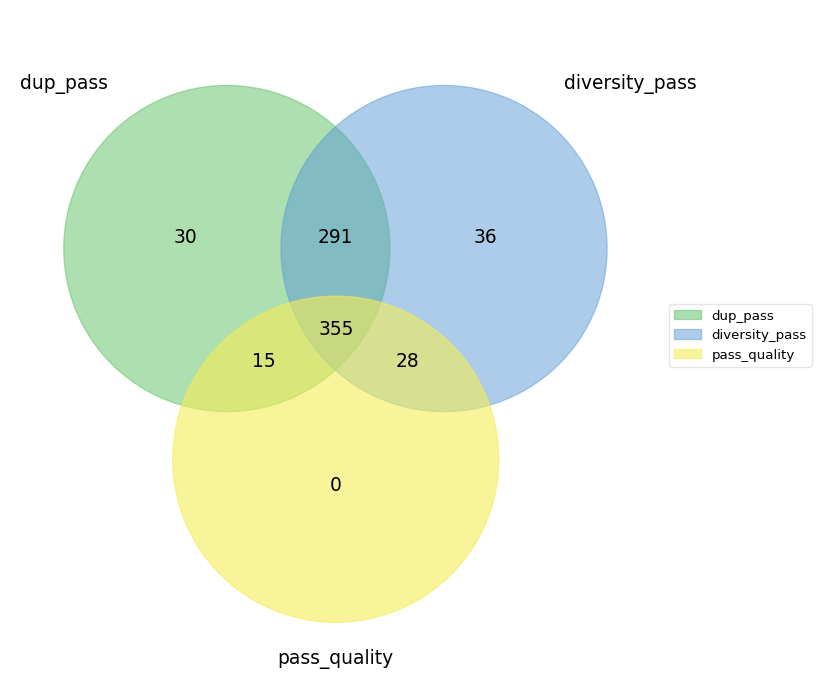

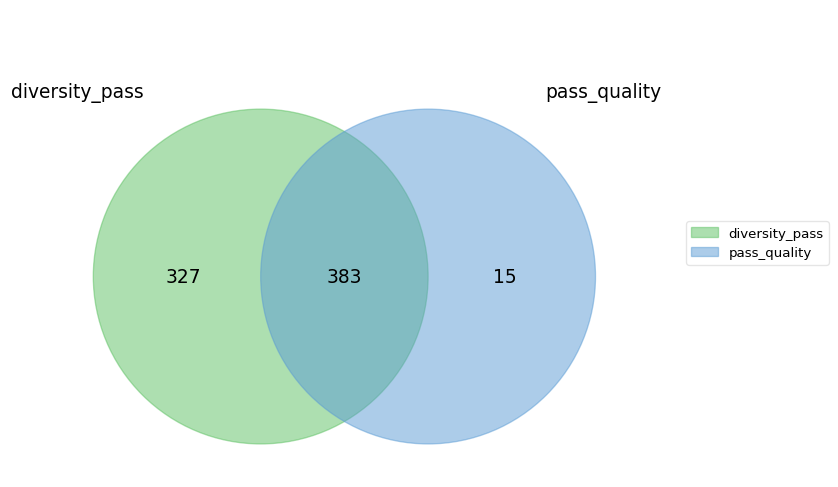

TypeError: 'set' object is not subscriptable

In [15]:
df = get_filtered_joined_results()

print(f"{df[df.user_explanation.notnull()].user_explanation=}")
print(f"{df[df.user_explanation.notnull()].user_explanation.str.count(' ')=}")
agg = df.groupby(['resp_cat', 'text_hash'])['ans'].agg(['count', 'mean', 'std'])
print(agg)
# for group, vals in agg:
#     print(group, vals)